<a href="https://colab.research.google.com/github/MaeenMo/Computer-Vision-Barcode-Reader/blob/main/Computer_Vision.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Installing Requirements**

In [ ]:
# !pip install opencv-python
# !pip install matplotlib

# **Mount Drive**

In [ ]:
from google.colab import drive
drive.flush_and_unmount()
drive.mount('/content/drive')
omarVar = "/content"
maeenVar = "/content/drive/MyDrive/Colab Notebooks/Vision"

Mounted at /content/drive


# **Barcode Reader**

## Import Libraries

cv2 is the OpenCV library in Python, which stands for Open Source Computer Vision Library. It's a powerful tool for computer vision tasks and image processing. Here are some reasons why we use cv2:
* Image Loading and Saving: OpenCV allows you to read images from files and save processed images back to files.
* Image Preprocessing: It provides various functions for image preprocessing, such as blurring, thresholding, and noise reduction.
* Feature Detection: OpenCV includes algorithms for detecting features like edges, contours, and keypoints.
* Geometric Transformations: You can perform operations like rotation, scaling, and translation on images.
* Object Detection: OpenCV supports object detection techniques, including face detection and barcode detection.
* Video Processing: It can handle video capture and processing, making it useful for real-time applications.

numpy is a fundamental package for scientific computing in Python. Here are some reasons why we use numpy (imported as np for convenience):
* Efficient Array Operations: numpy provides support for large, multi-dimensional arrays and matrices, along with a collection of mathematical functions to operate on these arrays efficiently.
* Performance: Operations using numpy are generally faster than using Python's built-in lists due to its optimized C implementation.
* Linear Algebra: It includes functions for linear algebra, Fourier transform, and random number generation, which are essential for many computer vision tasks.
* Integration: numpy integrates well with other libraries like OpenCV (cv2), making it easier to perform complex image processing tasks.
*Convenience: It simplifies many operations, such as element-wise operations, reshaping, and broadcasting, which are common in image processing.

matplotlib.pyplot (imported as plt) is a plotting library in Python that is widely used for creating static, animated, and interactive visualizations. Here are some reasons why we use matplotlib.pyplot:
* Visualization: It allows you to visualize data in various forms, such as line plots, scatter plots, histograms, and more. This is crucial for understanding and interpreting data.
* Debugging: Visualizing intermediate steps in image processing helps in debugging and fine-tuning algorithms. For example, you can see the effects of preprocessing steps like blurring, thresholding, and edge detection.
* Presentation: It helps in creating clear and informative plots for presentations and reports, making it easier to communicate your findings.
* Customization: matplotlib.pyplot offers extensive customization options for plots, including titles, labels, legends, and color schemes, allowing you to create professional-quality visualizations.

In [ ]:
import cv2
import matplotlib.pyplot as plt
import numpy as np
import math

## Barcode Functions

### Plot Images

In [ ]:
def plot_images(img,title):
    plt.figure(figsize=(10, 6))
    plt.title(title)
    plt.imshow(img, cmap="gray")
    plt.axis("off")
    plt.show()
def plot_images_fig(img,ax,title):
    ax.set_title(title)
    ax.imshow(img, cmap="gray")
    ax.axis("off")


### Plot Contour

In [ ]:
def plot_contours(img,title):
    plt.figure(figsize=(10, 6))
    plt.title(title)
    plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
    plt.axis("off")
    plt.show()

### Plot Histogram

In [ ]:
def plot_histogram(image, ax, title):
    hist = cv2.calcHist([image], [0], None, [256], [0, 256])
    ax.plot(hist)
    ax.set_title(title)
    ax.set_xlim([0, 256])
    ax.set_xlabel("Pixel Intensity")
    ax.set_ylabel("Frequency")


### Crop Barcode

In [ ]:
def crop_barcode(image, tcName):
    # Step 1: Binarize the image
    _, binary = cv2.threshold(image, 200, 255, cv2.THRESH_BINARY_INV)

    # Binarized Image
    plot_images(binary,"Phase 2: Binarized Image")

    # Step 2: Morphological closing with a larger kernel to merge barcode lines
    # Bar Width is 8 pixels & Gap between bars & Numbers is 13 pixels
    # Hence width > 8 (35) & height > 13 (35) For thin numbers font
    kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (35, 35))
    closed = cv2.morphologyEx(binary, cv2.MORPH_CLOSE, kernel)

    # Morphological Closing
    plot_images(closed,"Phase 3: Morphological Closing")

    # Find contours
    contours, _ = cv2.findContours(closed.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    # Contour Drawing
    contoured_image = cv2.cvtColor(image, cv2.COLOR_GRAY2BGR)  # Convert to color for drawing
    cv2.drawContours(contoured_image, contours, -1, (0, 0, 255), 2)  # Red color for contours

    plot_contours(contoured_image,"Phase 4: Contour Drawing")

    # Initialize variables to find the largest bounding box
    x_min, y_min, x_max, y_max = float('inf'), float('inf'), 0, 0
    found = False

    # Loop through contours
    for c in contours:
        x, y, w, h = cv2.boundingRect(c)
        aspect_ratio = w / float(h)

        # Adjusted criteria for detection
        if w > 100 and h > 50 and aspect_ratio > 1.5:
            x_min = min(x_min, x)
            y_min = min(y_min, y)
            x_max = max(x_max, x + w)
            y_max = max(y_max, y + h)
            found = True

    # Detected Contours with Bounding Box
    output = cv2.cvtColor(image, cv2.COLOR_GRAY2BGR)  # Convert to color for rectangle
    if found:
        # gap size + numbers height / total height = (34 + 13) / 247 = 19.03%
        # We chose percentage to be generic when scaling barcode image
        height_adjustment = int((y_max - y_min) * 0.1903)  # Exclude bottom 19.03%
        y_max -= height_adjustment
        cv2.rectangle(output, (x_min, y_min), (x_max, y_max), (0, 255, 0), 3)

    plot_contours(output,"Phase 5: Detected Contours with Bounding Box")

    # Cropped Barcode
    if found:
        cropped_image = image[y_min:y_max, x_min:x_max]

        plot_images(cropped_image,"Phase 6: Cropped Barcode")

        # To save cropped image
        save_path = f"{omarVar}/Output/{tcName}_cropped_barcode.jpg"
        cv2.imwrite(save_path, cropped_image)
        save_path = f"{maeenVar}/Output/{tcName}_cropped_barcode.jpg"
        cv2.imwrite(save_path, cropped_image)
        print(f"Cropped barcode saved at: {save_path}")
    else:
        print("No bounding box found for cropping!")

    return cropped_image

## **TC1: Recognize Centered Barcode**

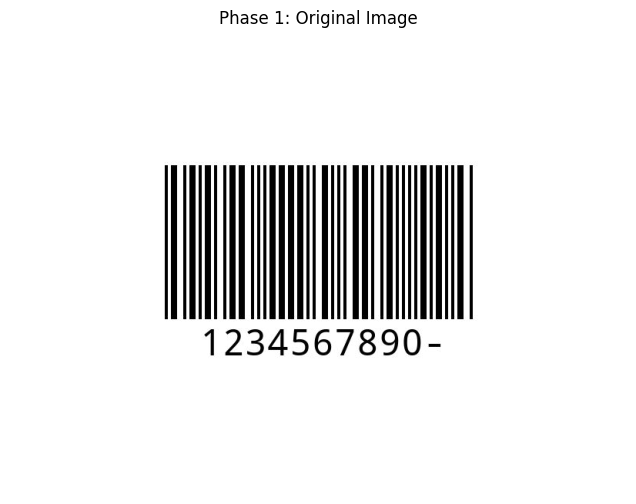

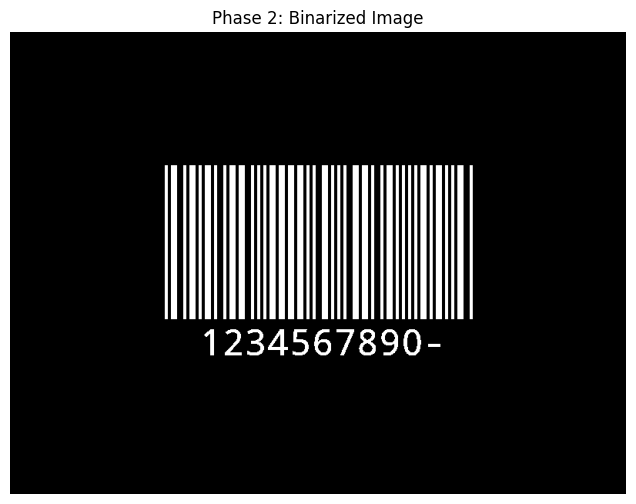

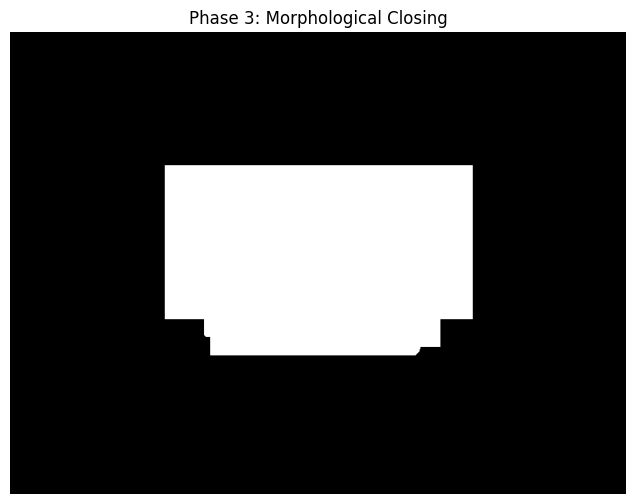

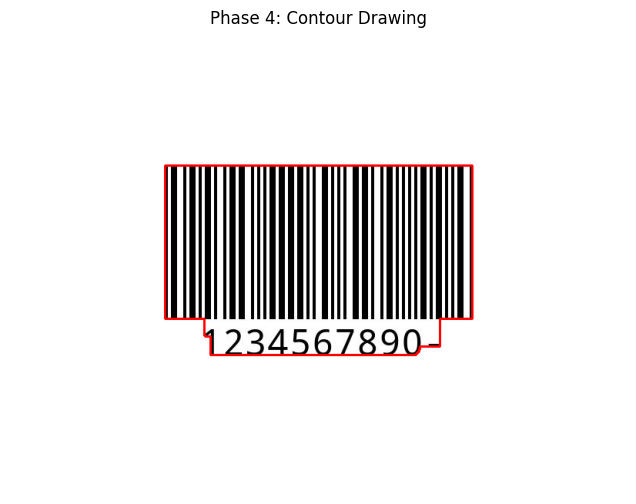

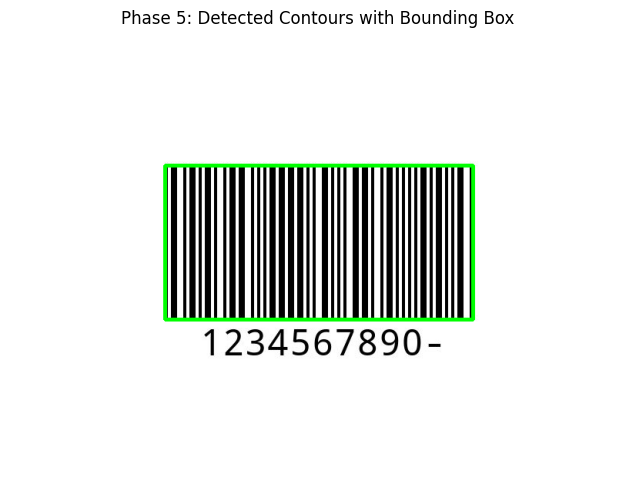

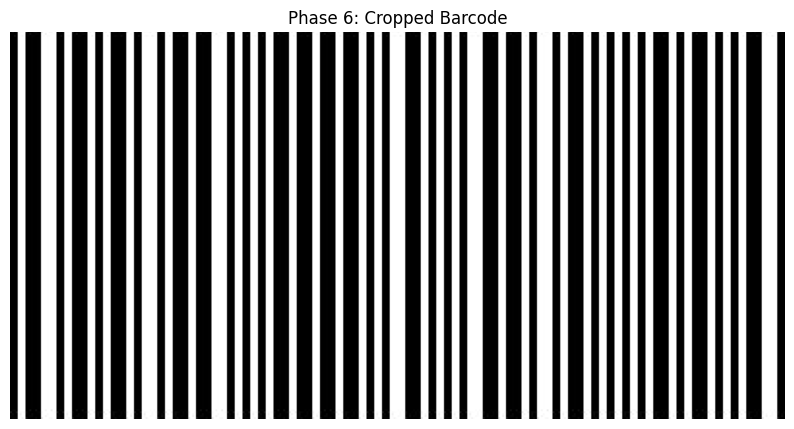

Cropped barcode saved at: /content/Output/01 - lol easy_cropped_barcode.jpg
BLABLABLA


In [ ]:
image_path = f"{omarVar}/Test Cases/01 - lol easy.jpg"
image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
# Original Image
plot_images(image,"Phase 1: Original Image")
crop_barcode(image, "01 - lol easy")

## **TC2: Recognize Shifted Barcode**

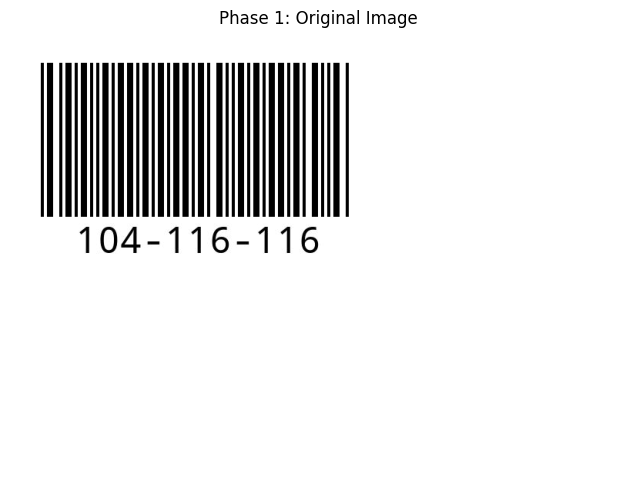

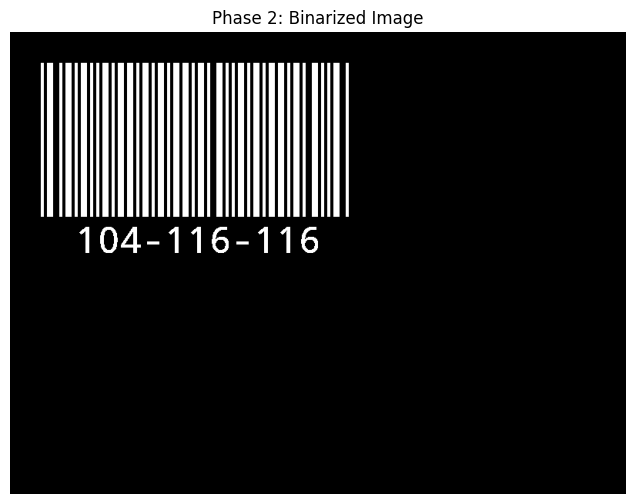

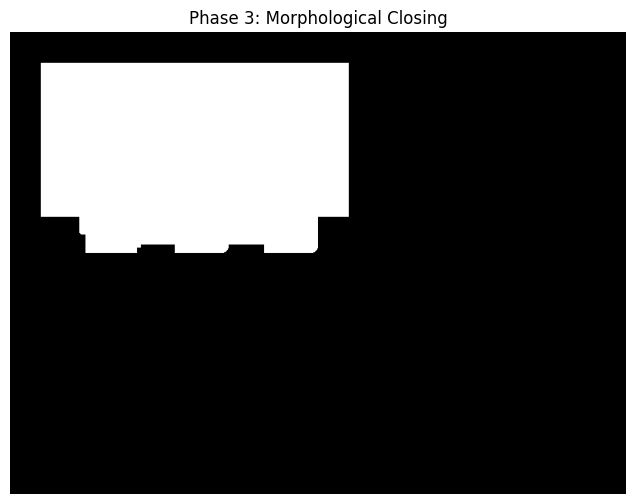

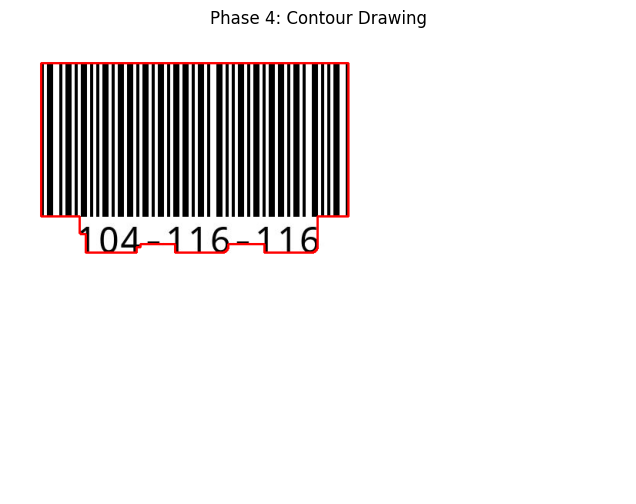

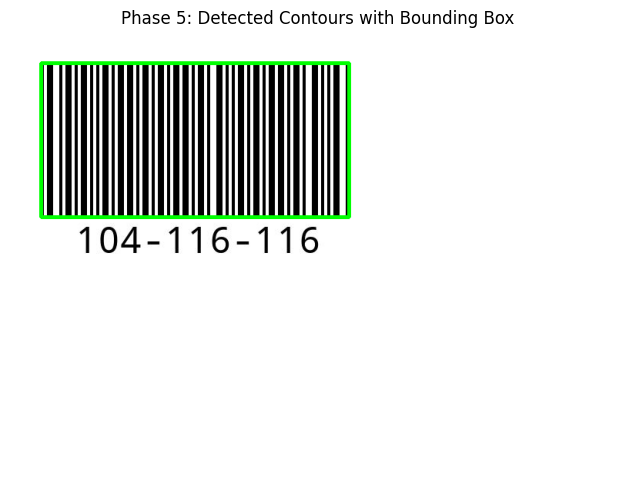

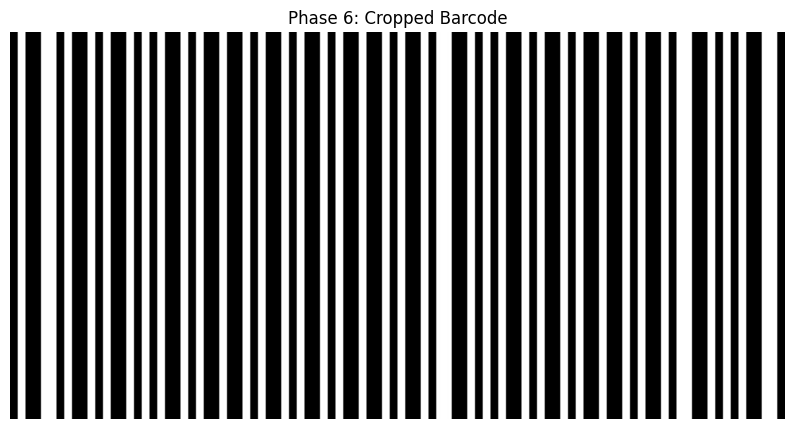

Cropped barcode saved at: /content/Output/02 - still easy_cropped_barcode.jpg


array([[0, 0, 1, ..., 1, 0, 0],
       [0, 0, 1, ..., 1, 0, 0],
       [0, 0, 1, ..., 1, 0, 0],
       ...,
       [0, 0, 1, ..., 1, 0, 0],
       [0, 0, 1, ..., 1, 0, 0],
       [0, 0, 1, ..., 1, 0, 0]], dtype=uint8)
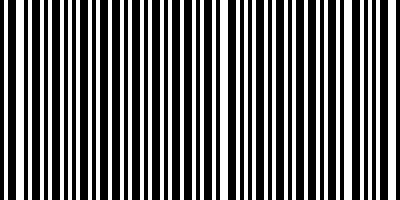

In [ ]:
image_path = f"{omarVar}/Test Cases/02 - still easy.jpg"
image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
# Original Image
plot_images(image,"Phase 1: Original Image")
crop_barcode(image, "02 - still easy")

## **TC 4: Recognize Blurred Barcode**

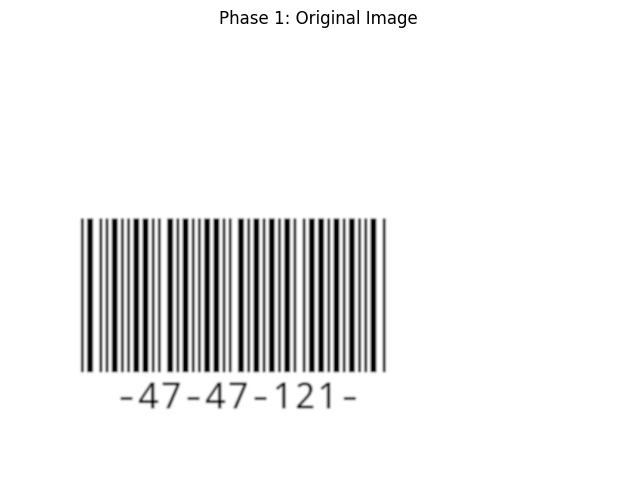

Mean Difference: 4.141029166666667
Image is blurred. Applying sharpening...


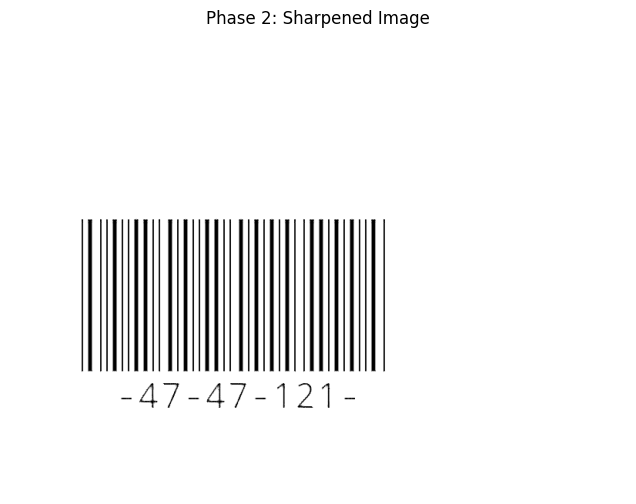

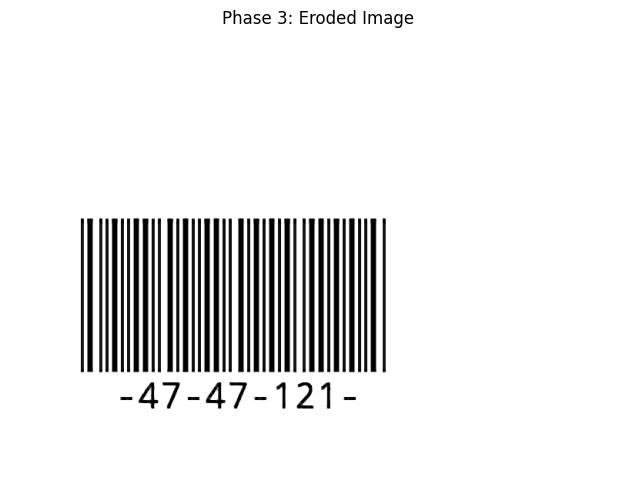

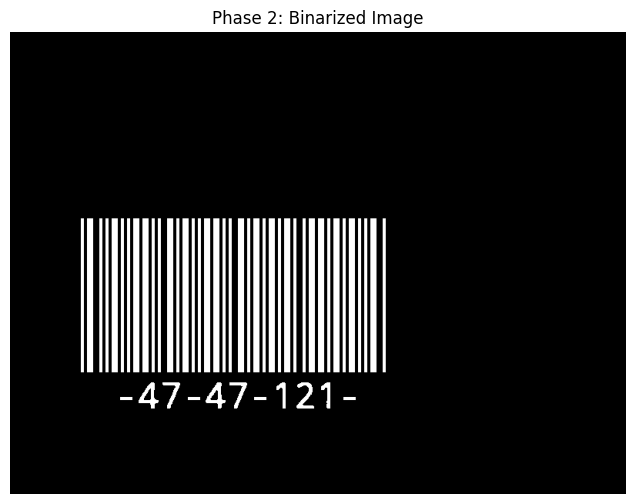

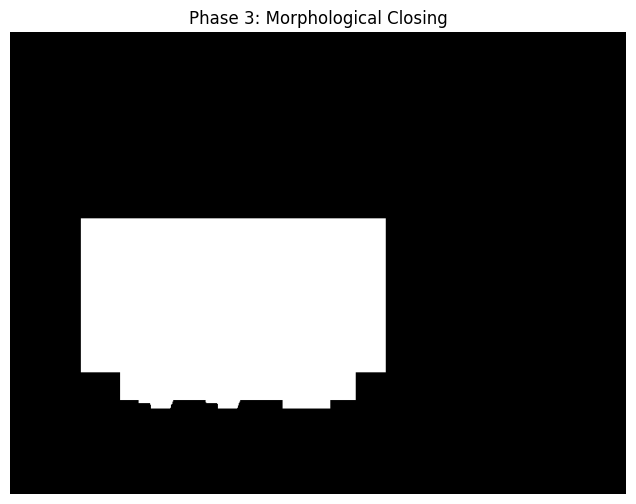

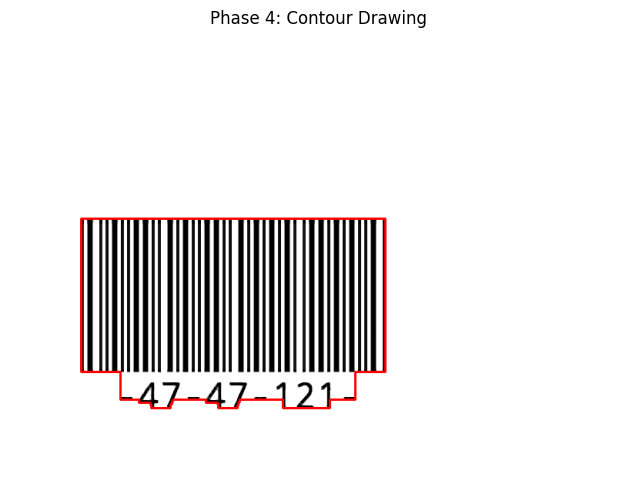

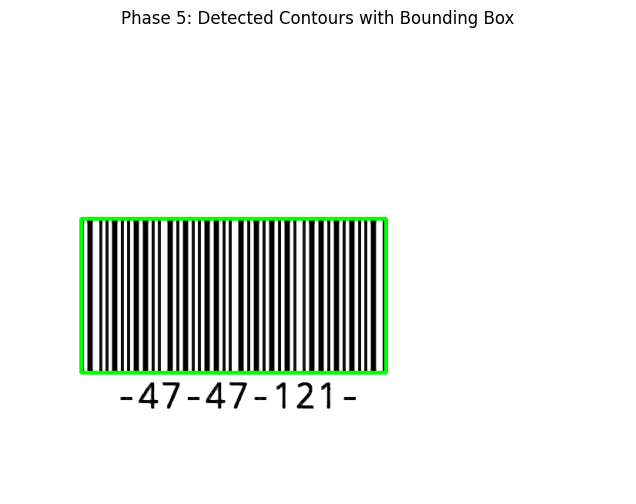

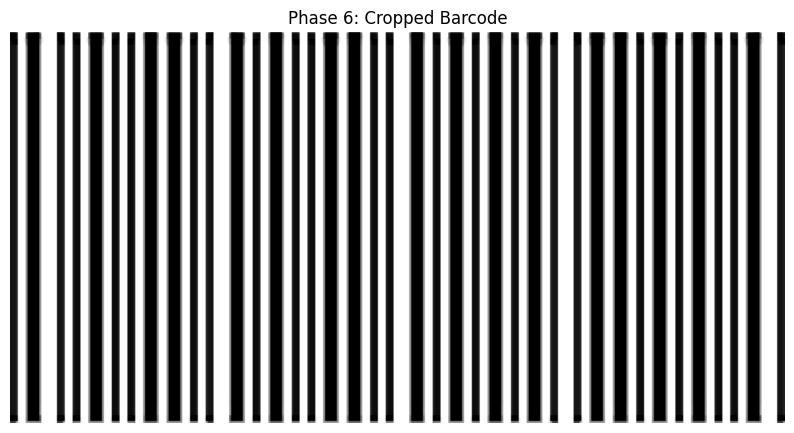

Cropped barcode saved at: /content/Output/04 - fen el nadara_cropped_barcode.jpg


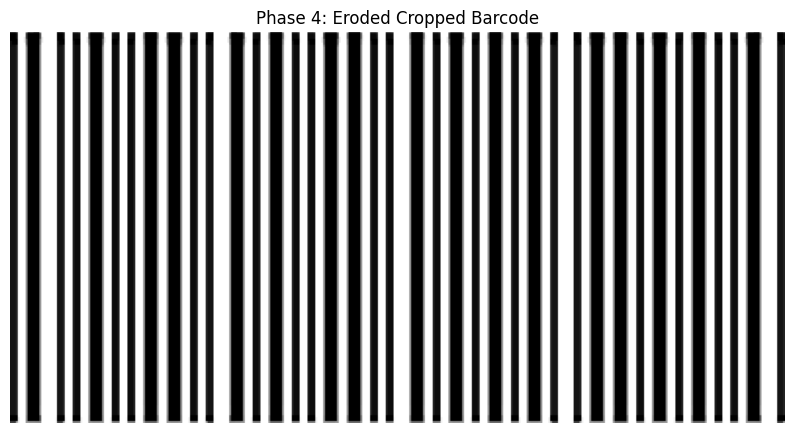

True

In [ ]:
# For threshold = 5, is suitable with medium resolution images,
# But if there high resolution image with low blur intensity,
# We need to increase the threshold to 10 or 15
# --------------------------------------------------------------
# For kernel size of (5 x 5) to catch high blur intensities,
# But can use (7 x 7) or (9 x 9) but will take more computations
def is_blurred(image, threshold=5.0, kernel_size=(5, 5)):
    # Step 1: Apply an average filter (smoothing)
    blurred_image = cv2.blur(image, kernel_size)

    # Step 2: Compute the absolute difference between the original and blurred image
    difference = cv2.absdiff(image, blurred_image)

    # Step 3: Compute the mean of the difference
    mean_difference = np.mean(difference)
    print(f"Mean Difference: {mean_difference}")

    # Step 4: Compare the mean difference with the threshold
    return mean_difference < threshold

# Function to sharpen an image
def sharpen_image(image):
    # Step 1: Apply the Laplacian filter
    laplacian = cv2.Laplacian(image, cv2.CV_64F)

    # Step 2: Convert Laplacian back to the same data type as the original image
    laplacian = np.uint8(np.absolute(laplacian))

    # Step 3: Sharpen by adding the Laplacian to the original image
    alpha = 2 # Weight multiplied by original image
    beta = -2 # Weight multiplied by laplacian image
    sharpened = cv2.addWeighted(image, alpha, laplacian, beta, 0)

    return sharpened

# Load the image
image_path = f"{omarVar}/Test Cases/04 - fen el nadara.jpg"
image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
# Original Image
plot_images(image,"Phase 1: Original Image")

# Check if the image is blurred
if is_blurred(image, threshold=5.0, kernel_size=(5, 5)):
    print("Image is blurred. Applying sharpening...")
    image = sharpen_image(image)
    # Phase 2: Sharpened Image
    plot_images(image,"Phase 2: Sharpened Image")
else:
    print("Image is not blurred. Proceeding...")

kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (3, 3))  # Adjust kernel size if needed
eroded_image = cv2.erode(image, kernel, iterations=1)
plot_images(eroded_image,"Phase 3: Eroded Image")

cropped_eroded_image = crop_barcode(eroded_image, "04 - fen el nadara")

plot_images(cropped_eroded_image,"Phase 4: Eroded Cropped Barcode")
save_path = f"{omarVar}/Output/04 - fen el nadara_eroded_cropped_barcode.jpg"
cv2.imwrite(save_path, cropped_eroded_image)

## 🚧 **TC 5: Recognize Salt & Pepper Barcode**


## **TC 5 & 6: Recognize Darken & Brighten Barcodes**

Mean value of the image: 13.4706375
Shift value: 118.5293625


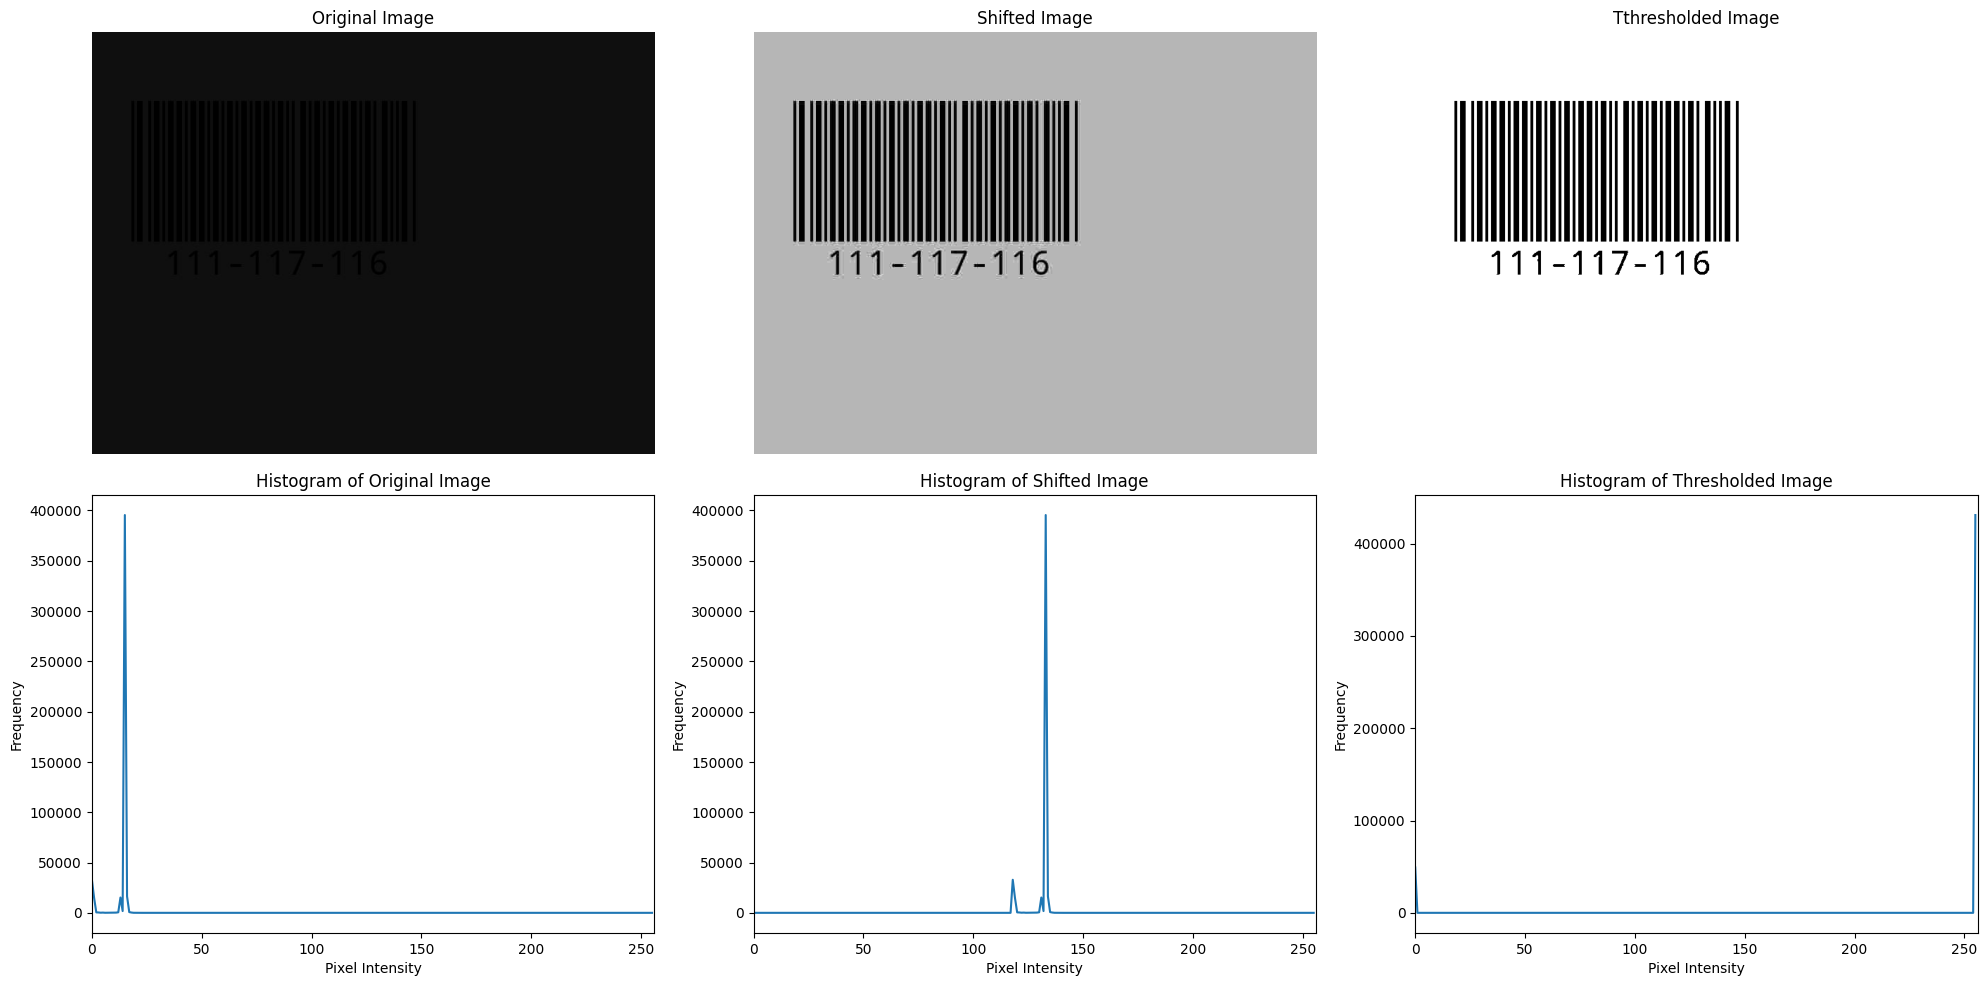

In [ ]:
def shift_histogram_to_middle(image):
    # Calculate the mean of the image
    mean_val = np.mean(image)
    print(f"Mean value of the image: {mean_val}")

    # Calculate the shift needed to center the histogram around 127 (middle point)
    shift_value = 127 - mean_val + 5  # This will adjust the image to be centered around 127
    print(f"Shift value: {shift_value}")

    # Shift the pixel values by the calculated amount
    image_shifted = image + shift_value

    # Clip the values to be within the valid range [0, 255]
    image_shifted = np.clip(image_shifted, 0, 255).astype(np.uint8)

    return image_shifted

def apply_threshold(image):
    # Set the threshold at 127 to classify pixels into black and white
    image[image < 127] = 0
    image[image >= 127] = 255
    return image


# Load image
image_path = f"{maeenVar}/Test Cases/05 - meen taffa el nour!!!.jpg"
# image_path = f"{maeenVar}/Test Cases/06 - meen fata7 el nour 333eenaaayy.jpg"
image = cv2.imread(image_path)

fig, axes = plt.subplots(2, 3, figsize=(20, 10))

# Plot original image
plot_images_fig(image,axes[0,0],"Original Image")

# Plot original histogram
plot_histogram(image, axes[1,0], "Histogram of Original Image")

# Define image again with gray scale
image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
# Shift histogram to the middle
shifted_image = shift_histogram_to_middle(image)

# Plot shifted image
plot_images_fig(shifted_image,axes[0,1],"Shifted Image")

# Plot shifted image histogram
plot_histogram(shifted_image, axes[1, 1], "Histogram of Shifted Image")

# Apply histogram stretching
stretched_image = apply_threshold(shifted_image)

# Show stretched image
plot_images_fig(stretched_image,axes[0,2],"Stretched Image")

# Plot threshold image histogram
plot_histogram(stretched_image,axes[1,2],"Histogram of Stretched Image")

plt.tight_layout()
plt.show()

cropped_shifted_image = crop_barcode(stretched_image,"05 - meen taffa el nour!!!")

# Save the adjusted image
save_path = f"{omarVar}/Output/05 - meen taffa el nour!!!.jpg"
cv2.imwrite(save_path, cropped_shifted_image)
save_path = f"{maeenVar}/Output/05 - meen taffa el nour!!!.jpg"
cv2.imwrite(save_path, cropped_shifted_image)

## TC 10: Recognize Bad Contrast Image Barcode

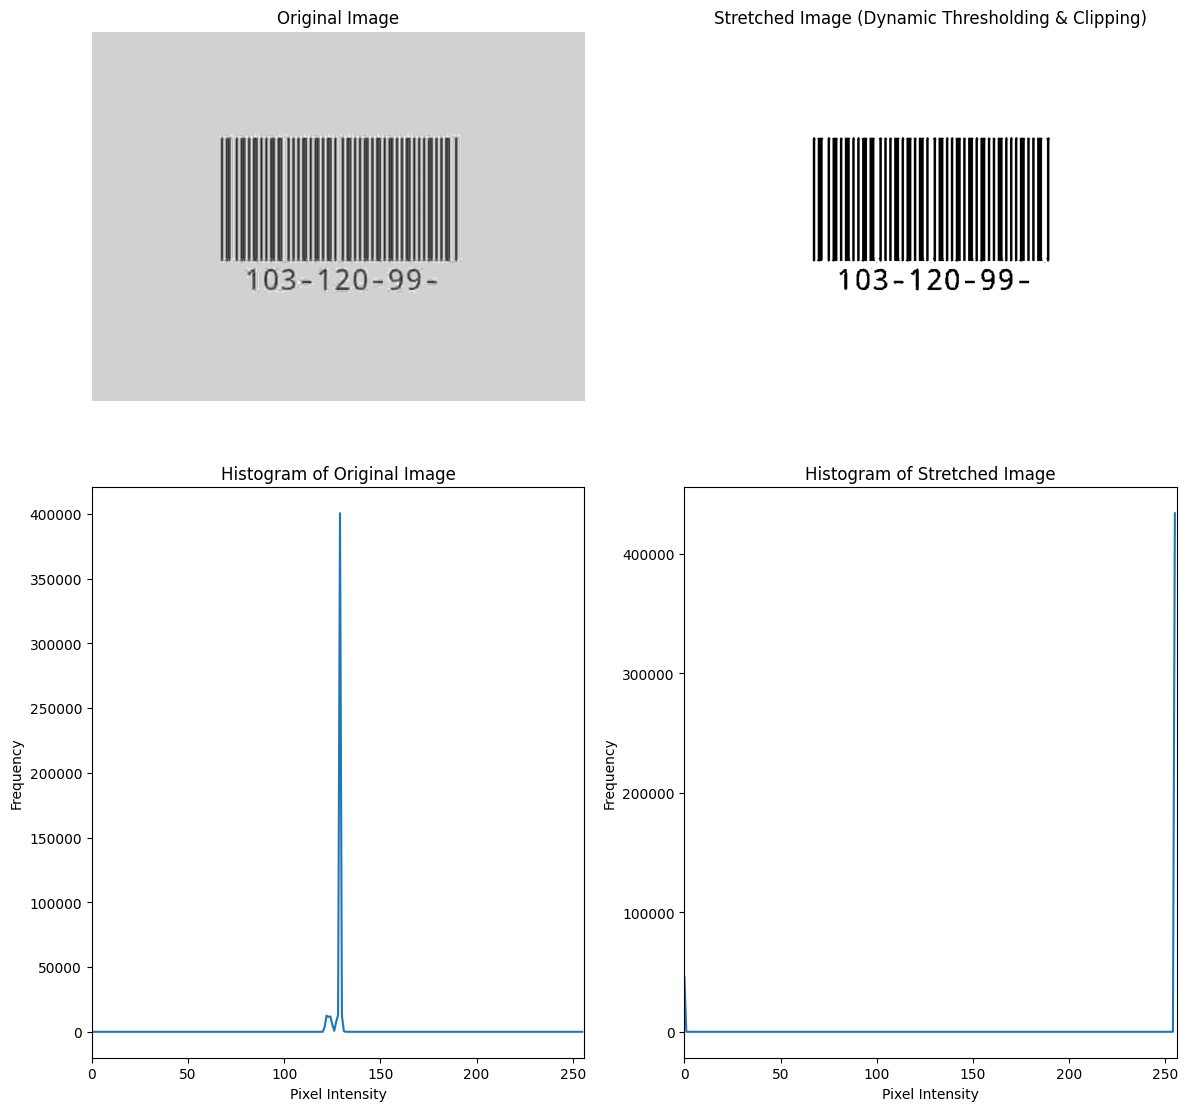

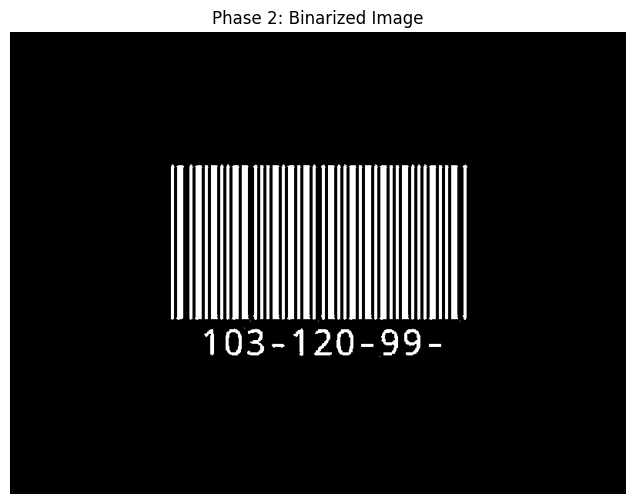

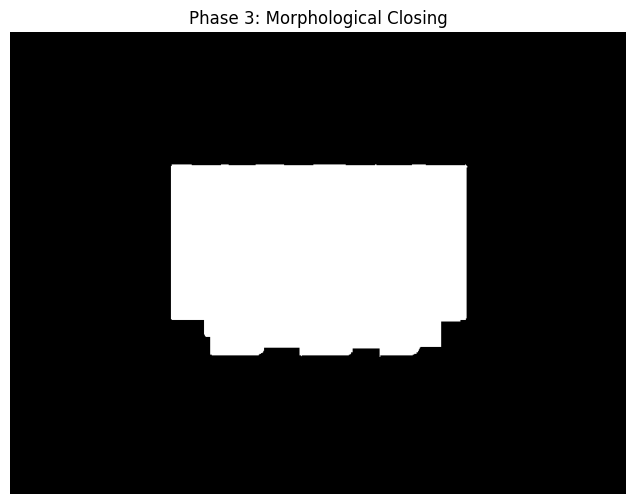

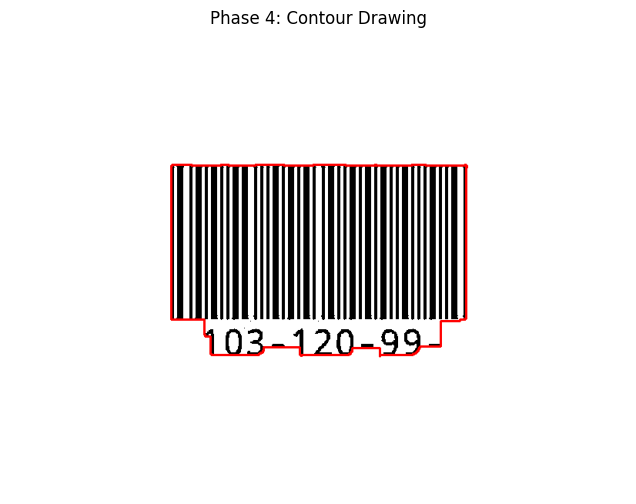

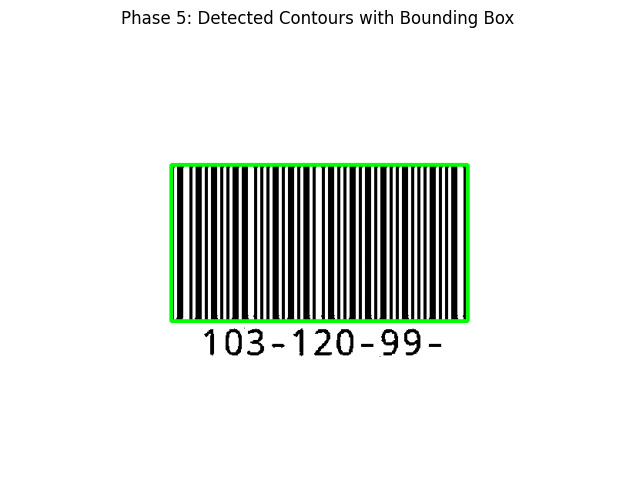

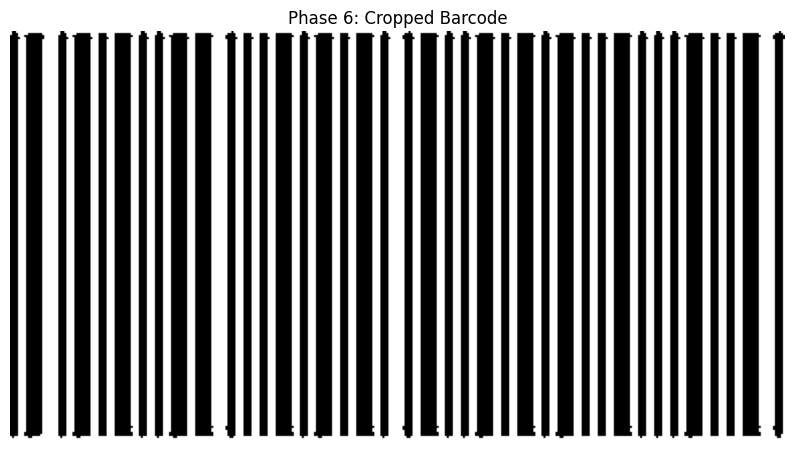

Cropped barcode saved at: /content/Output/10 - wen el kontraastttt_cropped_barcode.jpg


True

In [ ]:
def histogram_stretching_dynamic(image):
    # Create a figure with 2 subplots for the images and histograms
    fig, axes = plt.subplots(2, 2, figsize=(12, 12))

    # Display the original image
    axes[0, 0].imshow(image, cmap="gray")
    axes[0, 0].set_title("Original Image")
    axes[0, 0].axis("off")

    # Plot the histogram of the original image
    plot_histogram(image, axes[1, 0], "Histogram of Original Image")

    # Stretching Histogram by setting a threshold at middle of the histrogram
    image[image < 127] = 0
    image[image >= 127] = 255

    # Display the stretched image
    axes[0, 1].imshow(image, cmap="gray")
    axes[0, 1].set_title("Stretched Image (Dynamic Thresholding & Clipping)")
    axes[0, 1].axis("off")

    # Plot the histogram of the stretched image
    plot_histogram(image, axes[1, 1], "Histogram of Stretched Image")

    # Display the plots
    plt.tight_layout()
    plt.show()

    return image

# Path to your image
image_path = "/content/drive/MyDrive/Colab Notebooks/Vision/Test Cases/10 - wen el kontraastttt.jpg"
image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)

# Apply histogram stretching
stretched_image = histogram_stretching_dynamic(image)

cropped_stretched_image = crop_barcode(stretched_image,"10 - wen el kontraastttt")

# Save the adjusted image
save_path = f"/content/drive/MyDrive/Colab Notebooks/Vision/Output/10 - wen el kontraastttt.jpg"
cv2.imwrite(save_path, cropped_stretched_image)

## **Read Barcode**

In [ ]:
import numpy as np

# 0 means narrow, 1 means wide
NARROW = "0"
WIDE = "1"
code11_widths = {
    "00110": "Stop/Start",
    "10001": "1",
    "01001": "2",
    "11000": "3",
    "00101": "4",
    "10100": "5",
    "01100": "6",
    "00011": "7",
    "10010": "8",
    "10000": "9",
    "00001": "0",
    "00100": "-",
}

# image_path = f"{omarVar}/Output/04 - fen el nadara_eroded_cropped_barcode.jpg"
image_path = "/content/drive/MyDrive/Colab Notebooks/Vision/Output/06 - meen fata7 el nour 333eenaaayy.jpg"
image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)

# Apply adaptive thresholding
image_binary = cv2.adaptiveThreshold(image, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY_INV, 11, 2)

# Find contours to get the barcode elements (bars)
contours, _ = cv2.findContours(image_binary, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

# Extract the widths of the barcode bars
bar_widths = []
for contour in contours:
    x, y, w, h = cv2.boundingRect(contour)
    if h > 10:  # Avoid small noise contours
        bar_widths.append(w)

# Analyze bar widths (e.g., narrow bar size)
narrow_bar_size = np.median(bar_widths)  # Use median to avoid outliers

# Get the average of each column in your image
mean = image.mean(axis=0)

# Set a threshold based on the mean intensity of the image. We use narrow_bar_size as a guide.
threshold = math.ceil(np.median(mean)) + 10

# Set it to black or white based on its value
mean[mean <= threshold] = 1
mean[mean > threshold] = 0

# Convert to string of pixels in order to loop over it
pixels = ''.join(mean.astype(np.uint8).astype(str))

# Need to figure out how many pixels represent a narrow bar
narrow_bar_size = 0
for pixel in pixels:
    if pixel == "1":
        narrow_bar_size += 1
    else:
        break

wide_bar_size = narrow_bar_size * 2

digits = []
pixel_index = 0
current_digit_widths = ""
skip_next = False

while pixel_index < len(pixels):

    if skip_next:
        pixel_index += narrow_bar_size
        skip_next = False
        continue

    count = 1
    try:
        while pixels[pixel_index] == pixels[pixel_index + 1]:
            count += 1
            pixel_index += 1
    except:
        pass
    pixel_index += 1

    current_digit_widths += NARROW if count == narrow_bar_size else WIDE

    if current_digit_widths in code11_widths:
        digits.append(code11_widths[current_digit_widths])
        current_digit_widths = ""
        skip_next = True  # Next iteration will be a separator, so skip it

print(digits)

['Stop/Start', '-', '1', '1', '7', '-', '4', '6', '-', '9', '8', '-', 'Stop/Start']
